In [4]:
import sys
sys.path.insert(0, 'F:/Workspace/idx2/build/Source/Python/RelWithDebInfo')
sys.path.insert(0, '/home/sci/duong/Desktop/idx2/build/Source/Python')
#sys.path.insert(0, 'F:/Workspace/idx2/build/Source/Python/Debug')
import idx2Py as i2p
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from ipywidgets import *
import concurrent.futures

%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

vmin = -10
vmax = 10

## Set up color map

import colorsys

Points = [
  -10,
  -2.18552,
  -0.260014,
  0.00702716,
  0.372452,
  0.709768,
  10  
]

RGBPoints = [  
  [0.27843137254900002, 0.27843137254900002, 0.85882352941200002],
  [0.0, 0.33333333333333331, 1.0],
  [0.33333333333333331, 0.66666666666666663, 1.0],
  [0.0, 0.0, 0.49803921568627452],  
  [0.82745098039215681, 1.0, 0.73333333333333328],
  [1.0, 0.66666666666666663, 0.0],
  [0.87843137254899994, 0.30196078431399997, 0.30196078431399997]
]

def get_continuous_cmap(rgb_list, float_list=None):
  if float_list:
    # normalize the float list
    min_val = min(float_list)
    max_val = max(float_list)
    my_range = max_val - min_val
    float_list = [(v - min_val)/my_range for v in float_list]
    print(float_list)
  else:
    float_list = list(np.linspace(0, 1, len(rgb_list)))

  cdict = dict()  
  for num, col in enumerate(['red', 'green', 'blue']):
    col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(0, len(float_list))]
    cdict[col] = col_list
  cmp = matplotlib.colors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
  return cmp

my_cmap = get_continuous_cmap(RGBPoints, Points)

# Some helper functions

def get_file_name(input_dir, dataset, field, face, depth, time_from, time_to):
  return input_dir + '/' + dataset + '/' + field + '-face-' + repr(face) + '-depth-' + repr(depth) + '-time-' + repr(time_from) + '-' + repr(time_to) + '.idx2' 

def get_extent(dataset, face):
  if dataset == 'llc4320':
    if (face < 2):
      return (0, 0, 4320, 12960)
    elif (face > 2):
      return (0, 0, 12960, 4320)
    return (0, 0, 4320, 4320)
  elif dataset == 'llc2160':
    if (face < 2):
      return (0, 0, 2160, 6480)
    elif (face > 2):
      return (0, 0, 6480, 2160)
    return (0, 0, 2160, 2160)

# Query 
# extent should be a 4-tuple: (from_x, from_y, dim_x, dim_y)
def query_data(input_dir, dataset, times_per_file, times_per_brick, field, face, depth, time, downsampling, accuracy, extent=None):
  # determine the time step range to query from
  file_time_from    = (time // times_per_file) * times_per_file
  file_time_to      = file_time_from + times_per_file
  time_in_file      = time % times_per_file
  time_extent_from  = (time_in_file // times_per_brick) * times_per_brick
  
  # split the extent into 4 pieces
  if extent == None:
    extent = get_extent(dataset, face)
  e0 = extent
  e1 = (e0[0]           , e0[1]           , e0[2]//2   , e0[3]//2   )
  e2 = (e0[0]+(e0[2]//2), e0[1]           , e0[2]-e1[2], e0[3]//2   )
  e3 = (e0[0]           , e0[1]+(e0[3]//2), e0[2]//2   , e0[3]-e1[3])
  e4 = (e0[0]+(e0[2]//2), e0[1]+(e0[3]//2), e0[2]-e1[2], e0[3]-e1[3])
  e1 = (e1[0], e1[1], time_extent_from, e1[2], e1[3], times_per_brick)
  e2 = (e2[0], e2[1], time_extent_from, e2[2], e2[3], times_per_brick)
  e3 = (e3[0], e3[1], time_extent_from, e3[2], e3[3], times_per_brick)
  e4 = (e4[0], e4[1], time_extent_from, e4[2], e4[3], times_per_brick)

  file = get_file_name(input_dir, dataset, field, face, depth, file_time_from, file_time_to)
  print(file)
    
  array = None
  if extent[2] < 16 or extent[3] < 16: # if too small, don't spawn threads
    e = (extent[0], extent[1], time_extent_from, extent[2], extent[3], times_per_brick)
    array = i2p.DecodeExtent3f32(file, input_dir, extent, downsampling, accuracy)
  else:
    with concurrent.futures.ThreadPoolExecutor() as executor:
      f1 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e1, downsampling, accuracy)    
      f2 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e2, downsampling, accuracy)
      f3 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e3, downsampling, accuracy)
      f4 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e4, downsampling, accuracy)
      a1 = f1.result()
      a2 = f2.result()
      a3 = f3.result()
      a4 = f4.result()
      shape = (a1.shape[0], a1.shape[1] + a4.shape[1], a1.shape[2] + a4.shape[2])
      array = np.empty(shape)

      array[:, :a1.shape[1], :a1.shape[2]] = a1
      array[:, :a2.shape[1], a1.shape[2]:] = a2
      array[:, a1.shape[1]:, :a3.shape[2]] = a3
      array[:, a1.shape[1]:, a3.shape[2]:] = a4
  
  return array

C:\Users\Duong\AppData\Local\Temp\ipykernel_1208\1900702964.py:14: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


[0.0, 0.39072399999999996, 0.4869993, 0.500351358, 0.5186225999999999, 0.5354884, 1.0]


J:/nasa/llc2160_32/llc2160/u-face-0-depth-0-time-0-32.idx2
J:/nasa/llc2160_32/llc2160/u-face-1-depth-0-time-0-32.idx2
J:/nasa/llc2160_32/llc2160/u-face-3-depth-0-time-0-32.idx2
J:/nasa/llc2160_32/llc2160/u-face-4-depth-0-time-0-32.idx2


<IPython.core.display.Javascript object>


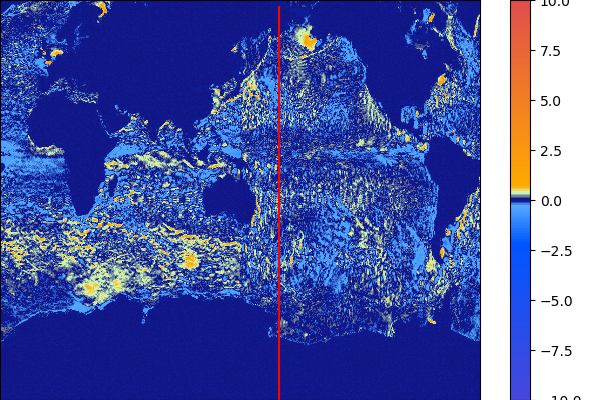

interactive(children=(IntSlider(value=100, description='x', layout=Layout(width='1000px'), max=800, step=10), …

In [13]:
# Vertical slicing along y (constant x) at a particular time step

input_dir = 'J:/nasa/llc2160_32'
dataset = 'llc2160'
times_per_file = 32
times_per_brick = 32
face = 0
depth = 0
time = 0
accuracy = 1
accuracy2 = 1
downsampling = [4, 4, 2]
downsampling2 = [0, 0, 0]
array = np.empty((1,1,1))
array2 = np.empty((1,1,1))

xbegin = 100

plt.close()

with concurrent.futures.ThreadPoolExecutor() as executor:
    f0 = executor.submit(query_data, input_dir, dataset, times_per_file, times_per_brick, 'u', 0, depth, time, downsampling, accuracy)    
    f1 = executor.submit(query_data, input_dir, dataset, times_per_file, times_per_brick, 'u', 1, depth, time, downsampling, accuracy)
    f3 = executor.submit(query_data, input_dir, dataset, times_per_file, times_per_brick, 'u', 3, depth, time, downsampling, accuracy)
    f4 = executor.submit(query_data, input_dir, dataset, times_per_file, times_per_brick, 'u', 4, depth, time, downsampling, accuracy)
    a0 = f0.result()
    a1 = f1.result()
    a3 = f3.result()
    a4 = f4.result()    
    dx = a0.shape[2]
    dy = a0.shape[1]
    dt = a0.shape[0]  
    array = np.empty((dt, dy, dx*4))
    array[:, :, dx*0:dx*1] = a0[:, :, :]    
    array[:, :, dx*1:dx*2] = a1[:, :, :]
    for tt in range(0, dt):
      array[tt, :, dx*2:dx*3] = np.rot90(a3[tt, :, :])
      array[tt, :, dx*3:dx*4] = np.rot90(a4[tt, :, :])
    #print(array.shape)

px = 1/plt.rcParams['figure.dpi']  # pixel in inches
fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
#plot = axs[0].imshow(array[0, :, :], origin = 'lower', cmap = my_cmap, aspect = 'auto', vmin = vmin, vmax = vmax)
#plt.colorbar(plot)
#plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)

#fig = plt.figure(figsize = (6, 4))
plot = plt.imshow(array[0, :, :], origin = 'lower', cmap = my_cmap, aspect = 'auto', vmin = vmin, vmax = vmax)
plt.colorbar(plot)

fig2, ax2 = plt.subplots()
fig2.set_size_inches(6, 6)
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)

line1 = None

def draw_line():
  global line1
  if line1 is not None:
    line1.pop(0).remove()
  line1 = ax.plot([xbegin, xbegin], [0,400], color = 'r')
  
def move_x(x):  
  global xbegin
  xbegin = x
  draw_line()
  #query_region()
  #draw_region()

#interact(f, t = widgets.IntSlider(min = 0, max = 63, step = 1, value = 0, layout = Layout(width = '500px')));
interact(move_x, x = widgets.IntSlider(min = 0, max = 800, step = 10, value = xbegin, layout = Layout(width = '1000px')));


# downsampling = [2, 2, 2]

# timestep = 0
# ndepths = 90
# n = 2160

# def to_face(f):
#   if (f >= 2):
#     return f + 1;
#   return f
    
def vertical_slice(x):
  global array2
  face = to_face(x // n)
  xx = x % n # local x coordinate within the face
  nx = 0
  ny = ndepths
  future_array = [None] * ndepths
  with concurrent.futures.ThreadPoolExecutor() as executor:
    extent = (xx, 0, time, 1, n * 3, 1)    
    if (face > 2):
      extent = (0, xx, time, n * 3, 1, 1)
    for d in range(0, ndepths):   
      file_name = get_file_name(input_dir, dataset, field, face, depth, time_from, time_to)
      future_array[d] = executor.submit(i2p.DecodeExtent3f32, file_name, input_dir, extent, downsampling, accuracy)

  array = None # store the whole result
  for d in range(0, ndepths):
    # figure out the shape of the output array once (at depth 0)
    a = future_array[d].result()
    if d == 0:
      if (face < 2):
        nx = a.shape[1]
      else:
        nx = a.shape[2]
      array = np.empty((ny, nx))
      
    if (face < 2):
      array[d, :] = a[0, :, 0]
    else:
      array[d, :] = a[0, 0, :]
  ax2.set_data(array2[0, :, :])
  plt.show()
  return

# interact(f, x = widgets.IntSlider(min = 0, max = 8639, step = 10, value = 0, layout = Layout(width = '800px')));